# Forest Fire Incidence in Northern Algeria: Report

In [60]:
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 8)

In [61]:
set.seed(1)

## Introduction

Algeria is traditionally considered to be semi-arid, with only 0.82% of its land covered by forest (Aini et. al., 2019). This forest is concentrated along the northern coast of the country along the Mediterranean Sea, and is characterized by vast coverage of shrublands and forests, and a humid climate (Curt et. al., 2020).  The northern region of Algeria is also characterized by high wildfire activity, experiencing 32 204 forest fires and burning a total of 16 954 km^2 of area between the years of 2001 - 2019 (Curt et. al., 2020). Most of the fires occur in the summer months, after the intense rainfalls of the spring and fall that promote lush vegetation growth (Curt et. al., 2020). Past studies have also suggested that the principal causation for fire activity is the combination of abundant fire fuel and dry, warm weather of the summer; however, it could also be linked to traditional agricultural activities, as farmers usually ignite fires in the summer to manage vegetation in cultivated lands (Aini et. al., 2019).

Daily temperature, relative humidity, rainfall, wind speed, and Fire Weather Index (FWI) data were collected in the Bejaia and Sidi Bel Abbes regions of Northern Algeria from June 1st to September 30th in 2012. FWI is divided into two categories (De Groot, 1987). Fuel moisture codes (FFMC, DMC, and DC) represent ratings of moisture for specific fuel depths. Fire behaviour indices include Initial Spread Index (ISI), expected rate of fire spread, Buildup Index (BUI), amount of fuel available, and Fire Weather Index, expected fire intensity. 122 observations were recorded for each of the regions.

Through this data analysis, our goal is to answer the following question: Can we predict whether the Bejaia or Sidi Bel Abbes regions in Algeria will experience a forest fire based upon bioclimatic conditions?


## Preliminary Exploratory Data Analysis

In [62]:
## Load datasets from URL

algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) %>%
    mutate(Region = "Bejaia")

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126) %>%
    mutate(Region = "Sidi Bel Abbes")

## Merge datasets of the two regions

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(Region = as_factor(Region))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

In [63]:
## Manually set values of incorrect column, convert DC and FWI to numeric type

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))


In [64]:
## Create training dataset

forest_fire_split <- algeria_forest_fire_all_data %>%
    initial_split(prop = 0.75, strata = Classes)
forest_fire_train <- training(forest_fire_split)
forest_fire_test <- testing(forest_fire_split)

forest_fire_train

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,09,2012,26,49,6,2.0,61.3,11.9,28.1,0.6,11.9,0.4,not fire,Sidi Bel Abbes
25,09,2012,28,70,15,0.0,79.9,13.8,36.1,2.4,14.1,3.0,not fire,Sidi Bel Abbes
26,09,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,Sidi Bel Abbes
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi Bel Abbes


The following table summarizes the predictors’ means and the number of observations for each of the classes. The classes are approximately balanced, with more observations of fire. Days with fire display higher mean temperatures, lower mean relative humidity, higher mean FFMC, and lower mean rainfall.

Next, we compare the distribution of the predictors between the 2 classes, examining differences which might suggest how each variable relates to fire incidence by constructing histograms for each predictor.

In [65]:
temp_distribution <- ggplot(forest_fire_train, aes(x = Temperature)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Temperature (C)", y = "Frequency", title = "Temperature") +
    theme(text = element_text(size = 20))

In [66]:
RH_distribution <- ggplot(forest_fire_train, aes(x = RH)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Relative Humidity (%)", y = "Frequency", title = "Relative Humidity") +
    theme(text = element_text(size = 20))

In [67]:
WS_distribution <- ggplot(forest_fire_train, aes(x = RH)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Wind Speed (km/h)", y = "Frequency", title = "Wind Speed") +
    theme(text = element_text(size = 20))

In [68]:
rain_distribution <- ggplot(forest_fire_train, aes(x = Rain)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Rainfall (mm, daily)", y = "Frequency", title = "Rainfall") +
    theme(text = element_text(size = 20))

In [69]:
FFMC_distribution <- ggplot(forest_fire_train, aes(x = FFMC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency", title = "FFMC") +
    theme(text = element_text(size = 20))

In [70]:
DMC_distribution <- ggplot(forest_fire_train, aes(x = DMC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Duff Moisture Code (DMC)", y = "Frequency", title = "DMC") +
    theme(text = element_text(size = 20))

In [71]:
DC_distribution <- ggplot(forest_fire_train, aes(x = DC)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Drought Code (DC)", y = "Frequency", title = "DC") +
    theme(text = element_text(size = 20))

In [72]:
ISI_distribution <- ggplot(forest_fire_train, aes(x = ISI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Initial Spread Index (ISI)", y = "Frequency", title = "ISI") +
    theme(text = element_text(size = 20))

In [73]:
BUI_distribution <- ggplot(forest_fire_train, aes(x = BUI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Buildup Index (BUI)", y = "Frequency", title = "BUI") +
    theme(text = element_text(size = 20))

In [74]:
FWI_distribution <- ggplot(forest_fire_train, aes(x = FWI)) +
    geom_histogram() +
    facet_grid(Classes ~ .) +
    labs(x = "Fire Weather Index (FWI)", y = "Frequency", title = "FWI") +
    theme(text = element_text(size = 20))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



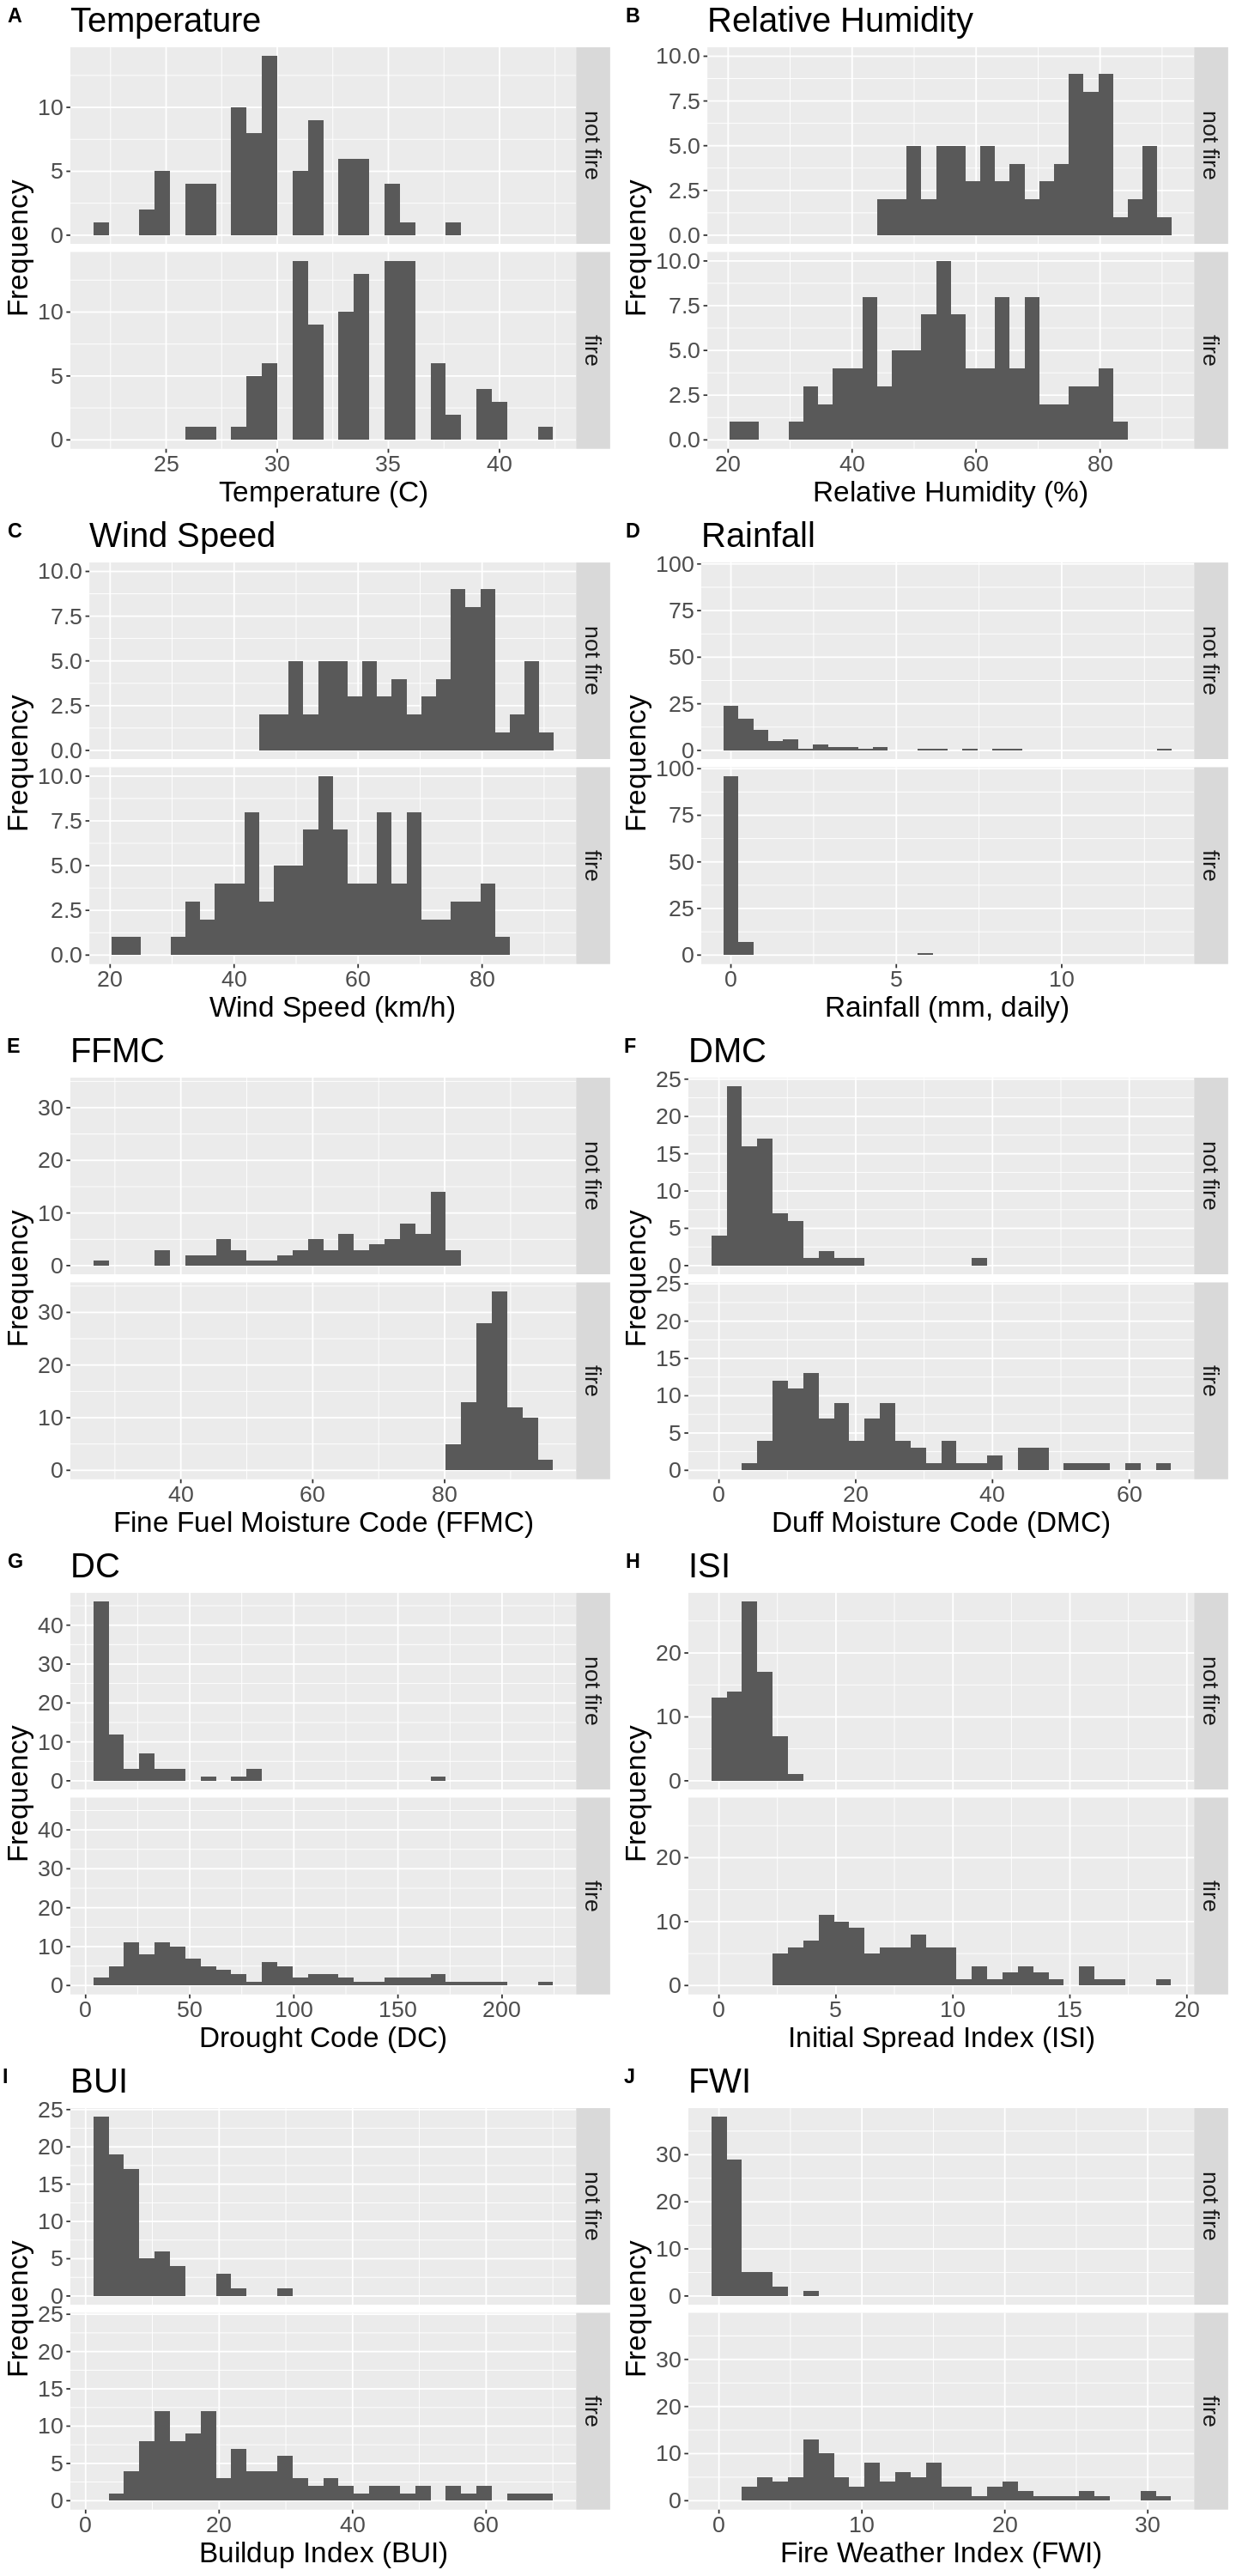

In [75]:
options(repr.plot.width = 12, repr.plot.height = 25)

plot_grid(
  temp_distribution, RH_distribution, WS_distribution, rain_distribution, FFMC_distribution, DMC_distribution, DC_distribution, ISI_distribution, BUI_distribution, FWI_distribution,
  labels = "AUTO", ncol = 2
)

We can see from the plots that the FFMC, ISI, BUI and FWI are the best predictors of a fire, and visually they appear much better than any other predictor, so we chose to use these four. We select these four predictors, then splitting the data in the training set and the testing set.

## Methods

We plan to use a k-nearest neighbours classification algorithm with cross-validation to predict whether there will be a fire on a given day. As BUI, ISI, and FWI, characterize fire behaviour, we decided that they would not be helpful in predicting the fire likelihood.  From the exploratory analysis, patterns appear in the values of temperature, humidity, rain, and FFMC based upon the fire classification; therefore, these will be the variables included in our algorithm. The results will be shown with scatterplots of the data, the predictors as axes, and colored by classification.

In [76]:
# STEP ALREADY DONE ABOVE
# forest_fire_split <- algeria_forest_fire_all_data %>% 
#     select(FFMC, ISI, BUI, FWI, Classes) %>%
#     initial_split(prop = 0.75, strata = Classes)
# forest_fire_train <- training(forest_fire_split)
# forest_fire_test <- testing(forest_fire_split)

In [77]:
## Explore means of predictor variables and the number of observations in each category

means <- forest_fire_train %>%
    group_by(Classes) %>%
    summarize(mean_FFMC = mean(FFMC),
             mean_ISI = mean(ISI),
             mean_BUI = mean(BUI),
             mean_FWI = mean(FWI),
             obs_count = n(),
             proportion = obs_count / nrow(forest_fire_train))

means

`summarise()` ungrouping output (override with `.groups` argument)



Classes,mean_FFMC,mean_ISI,mean_BUI,mean_FWI,obs_count,proportion
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
not fire,65.26000,1.260000,6.86125,0.92375,80,0.4347826
fire,87.63942,7.527885,24.48558,11.89135,104,0.5652174


Next, create a recipe for the model with our chosen predictors, as scale and center them to ensure that they all have an equal effect on the model. Afterwards, we create the model, and a vfold in order to find the best value for k.

In [78]:
fire_recipe <- recipe(Classes ~ FFMC + ISI + BUI + FWI, data = forest_fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

fire_vfold <- vfold_cv(forest_fire_train, v = 15, strata = Classes)

tuning_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_tune_spec) %>%
    tune_grid(resamples = fire_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- tuning_results %>%
    filter(.metric == "accuracy")

Here, we plot the values of k with their accuracy.

In [79]:
options(repr.plot.width = 8, repr.plot.height = 6)

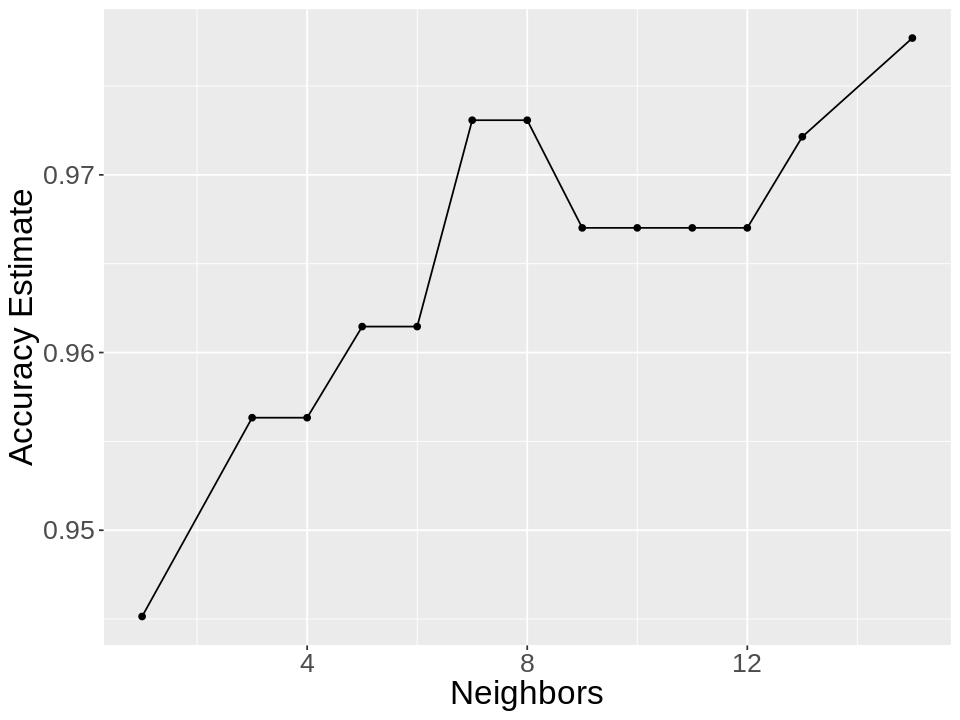

In [80]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20))
accuracy_vs_k

The graph does not have any distinct pattern, with three distinct peaks, however, the peak at 7 seems to have the least change around it, so we choose k = 7, and create a fit with our new value.

In [85]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
  set_engine("kknn") %>%
  set_mode("classification")

fire_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = forest_fire_train)

fire_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.0326087
Best kernel: rectangular
Best k: 7

Finally we test the accuracy of the model on the testing data that we seperated earlier. We apply the model to each observation, then compare the predicted class with the actual class.

In [86]:
fire_test_predictions <- fire_fit %>%
    predict(forest_fire_test) %>%
    bind_cols(forest_fire_test)

fire_results <- fire_test_predictions %>%
    metrics(estimate = .pred_class, truth = Classes)

fire_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9666667
kap,binary,0.9321267


And we get an accuracy of 98%, meaning the our model would correctly predict whether there is going to be a fire on a given day with 98% accuracy. 

## Expected Outcomes and Significance

We anticipate that FFMC will be the strongest predictor of fire due to the distinct separation in values observed in the histogram. It is expected that higher temperature, lower humidity, and minimal rain correspond to an incident of fire. 

Our findings may assist in determining whether a fire will occur based on bioclimatic conditions. This knowledge could improve interventions to prevent forest fires, protecting the ecosystems and residents of these regions.

The causes of forest fires in Algeria are widely unknown, with the causation for 85% of forest fires remaining unknown in 2020 (Pons, 2020). However, our data analysis could lead to asking whether rainfall, temperature, humidity, or FFMC directly cause a fire incidence.

In [88]:
options(repr.plot.width = 8, repr.plot.height = 6)

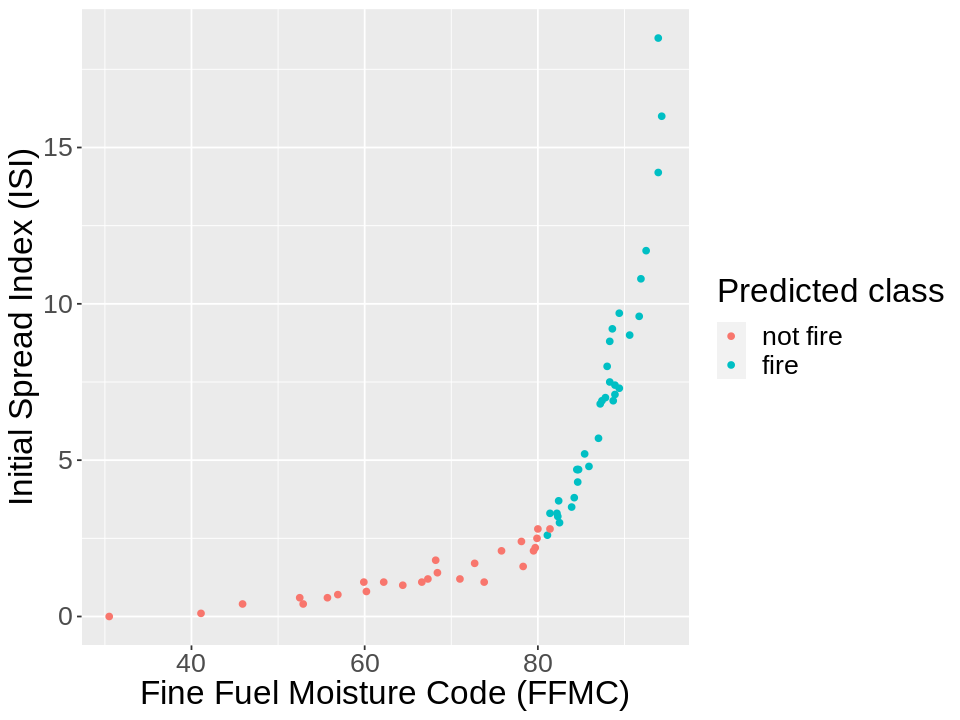

In [89]:
# TODO: Visualize results of analysis
# An example graph created below - unsure which combinations of predictors to use

fire_predictions <- ggplot(fire_test_predictions, aes(x = FFMC, y = ISI, colour = .pred_class)) +
    geom_point() +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Initial Spread Index (ISI)", colour = "Predicted class") +
    theme(text = element_text(size = 20))

fire_predictions

## Discussion

At the beginning of this analysis, we expected that FFMC would be the strongest predictor of fire with a boundary between classes at around FFMC = 80, and that higher temperature, lower humidity, and minimal rain would also correspond to an incident of fire.

To evaluate our hypothesis, we construct histograms of the distribution of the predictor variables in the testing set, faceted by their predicted class, and compare them to corresponding distributions of the training set when faceted by actual classes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



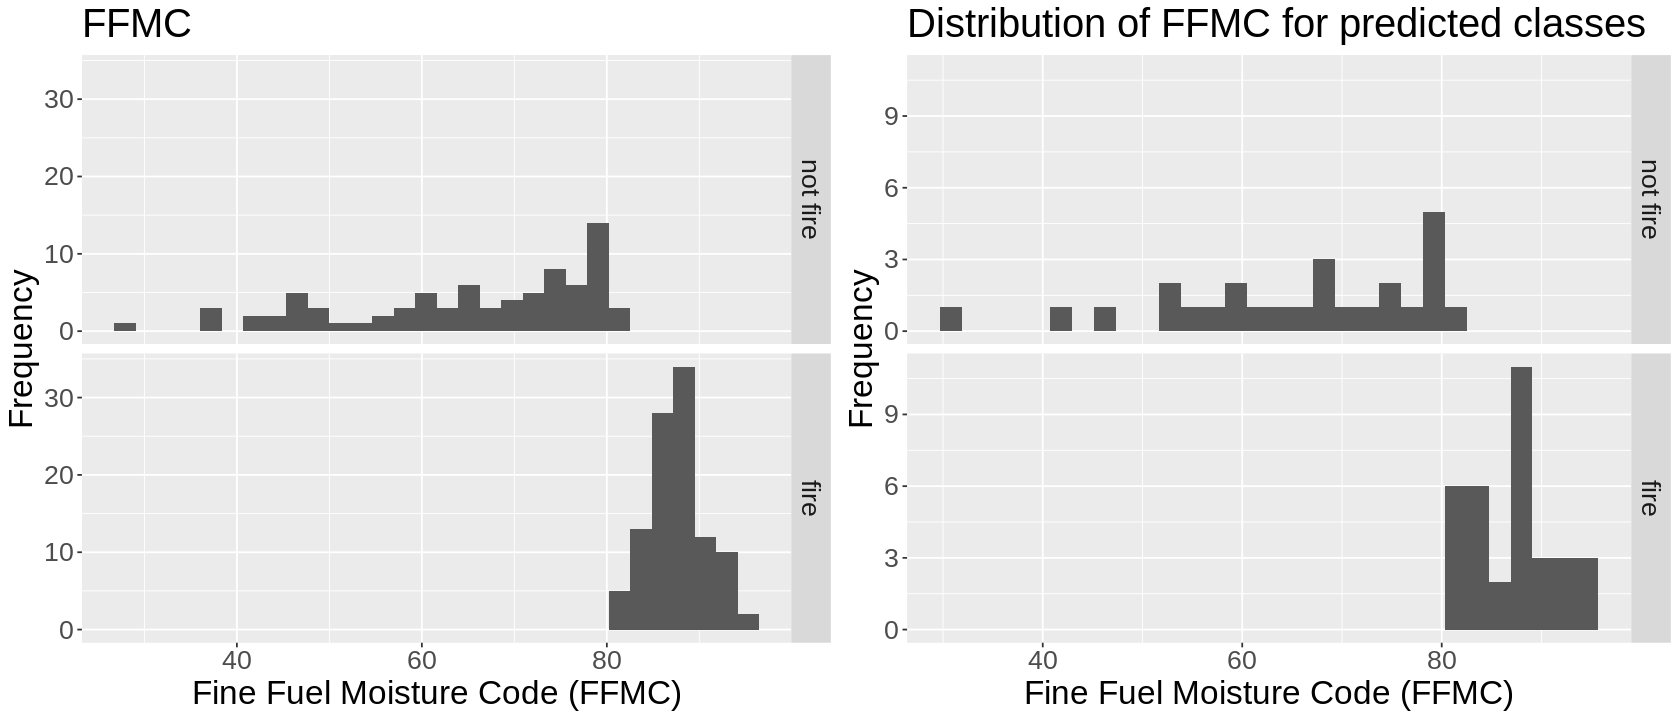

In [97]:
options(repr.plot.width = 14, repr.plot.height = 6)

predicted_FFMC_dist <- ggplot(fire_test_predictions, aes(x = FFMC)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Fine Fuel Moisture Code (FFMC)", y = "Frequency", title = "Distribution of FFMC for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(FFMC_distribution, predicted_FFMC_dist, ncol = 2)

Based on the distribution of FFMC for observations classified as fire and not fire, the finished KNN model generally classifies unseen obseravations with FFMC > 80 as cases of fire, which agrees with our expectation and observed patterns in the training set. In the Fire Weather Index model, the FFMC quantifies **(CITATION)** the ease of fire ignition under current bioclimactic conditions; it therefore makes sense that a sufficiently high FFMC is related to an actual occurrence of fire.

The classification results appear more mixed when FFMC is close to 80. This seems acceptable, however, given that we would also expect some uncertainty in real life when conditions are only somewhat conducive to fire ignition.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



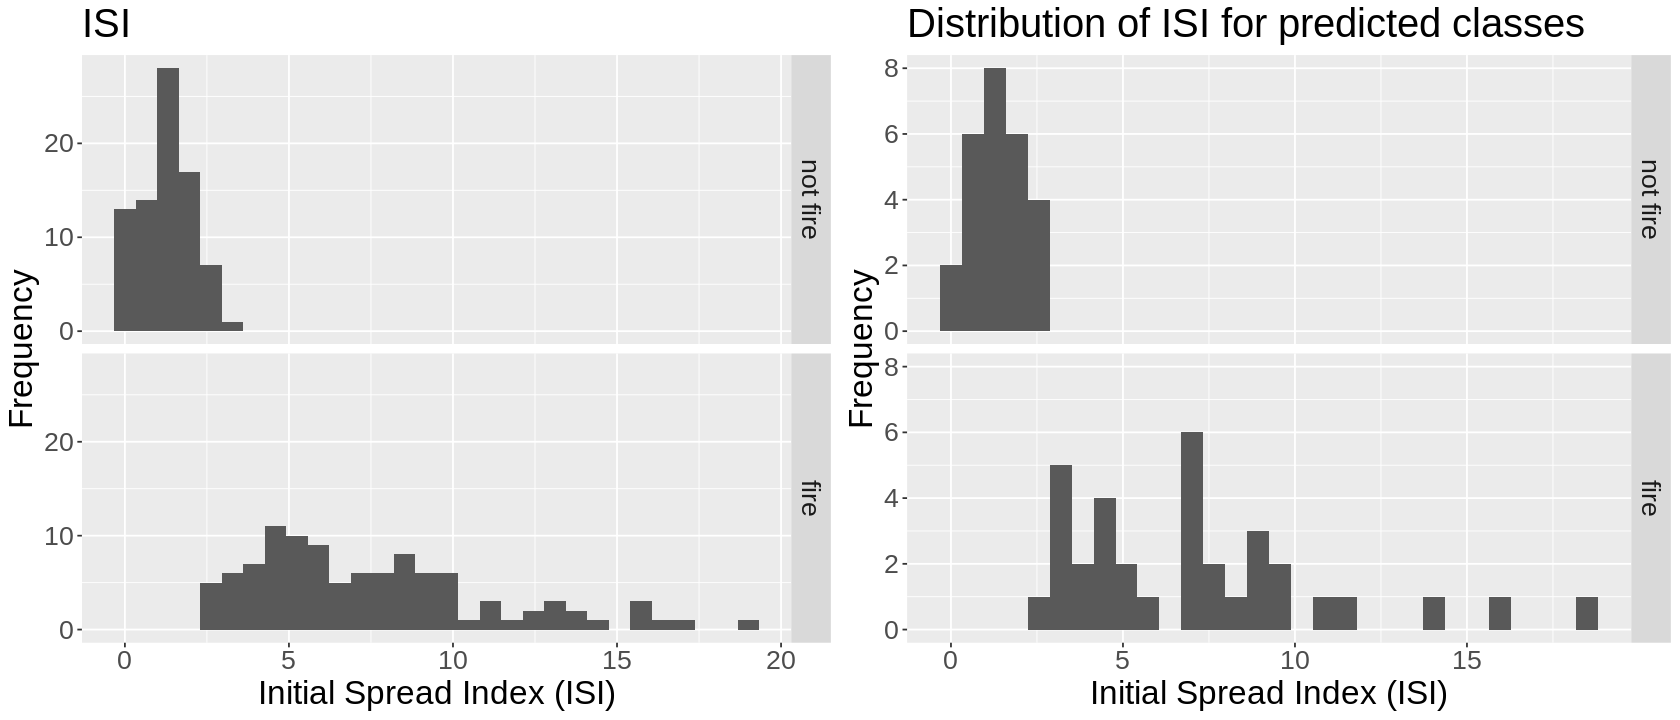

In [95]:
predicted_ISI_dist <- ggplot(fire_test_predictions, aes(x = ISI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Initial Spread Index (ISI)", y = "Frequency", title = "Distribution of ISI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(ISI_distribution, predicted_ISI_dist, ncol = 2)

The distribution of temperature for observations classified as fire versus not fire is similar to the distributions of temperature separated by actual classes in the training set. In general, observations with higher temperatures are classified as fire by the finished KNN model - as expected - but the distributions also overlap between 27 and 35 °C. We may hypothesize that other predictor variables sway the classifier's decision in these ambiguous situations; for example, in **(FIGURE X - CITE THE SCATTERPLOT ABOVE)**, certain observations with moderate temperature but very high FFMC were classified as fire.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



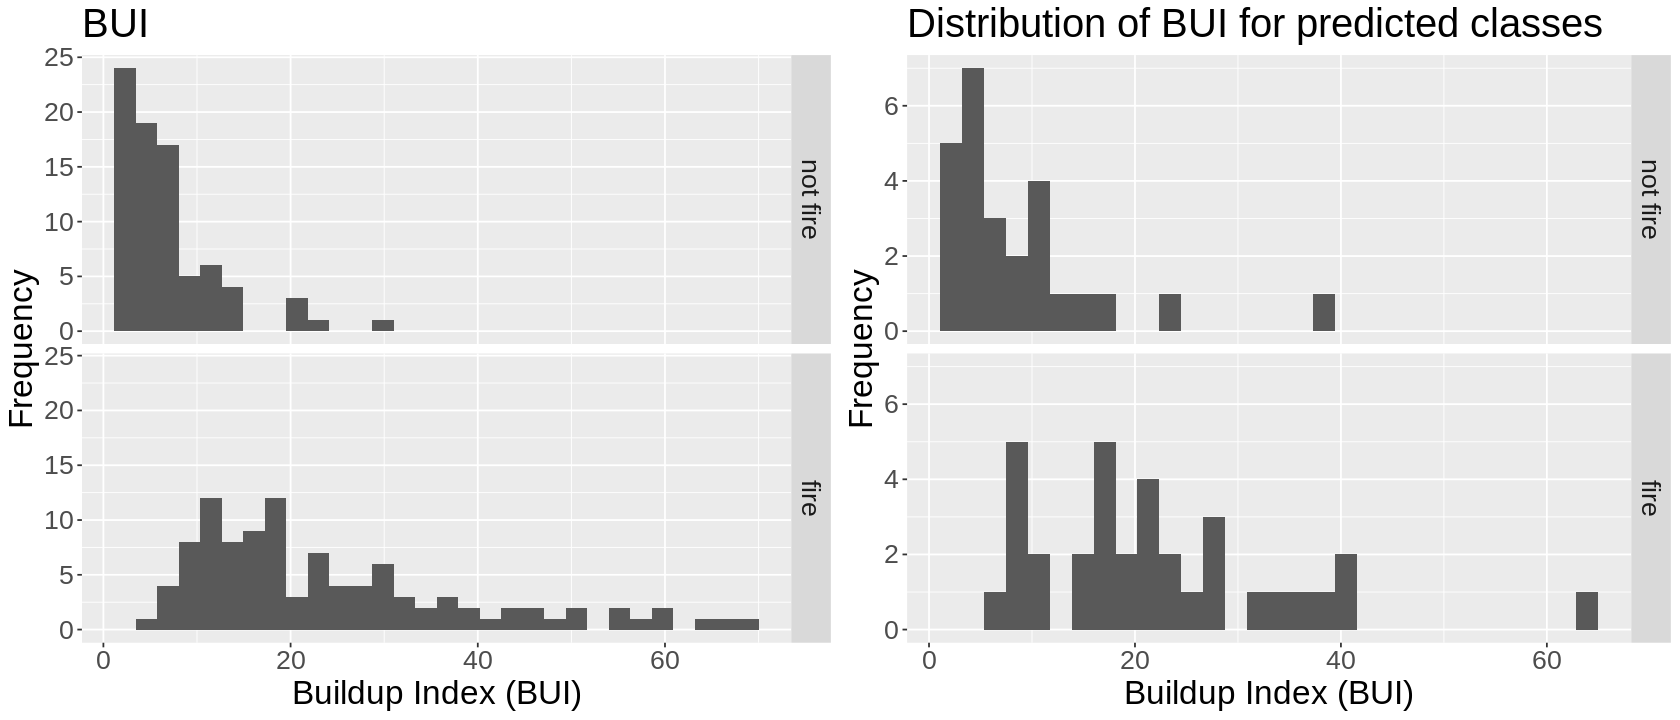

In [98]:
predicted_BUI_dist <- ggplot(fire_test_predictions, aes(x = BUI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Buildup Index (BUI)", y = "Frequency", title = "Distribution of BUI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(BUI_distribution, predicted_BUI_dist, ncol = 2)

The distributions of rainfall for predicted classes and for the true classes are very similar. Notably, in the commonly observed situation where daily rainfall is 0, the classifier usually classifies the observation as a case of fire. There appear to be some exceptions, however; this suggests that the classifier can differentiate among observations with little to no rainfall with reasonable accuracy on the basis of other predictors. **(It would be nice if we had a scatterplot or other visualization to back this up)**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



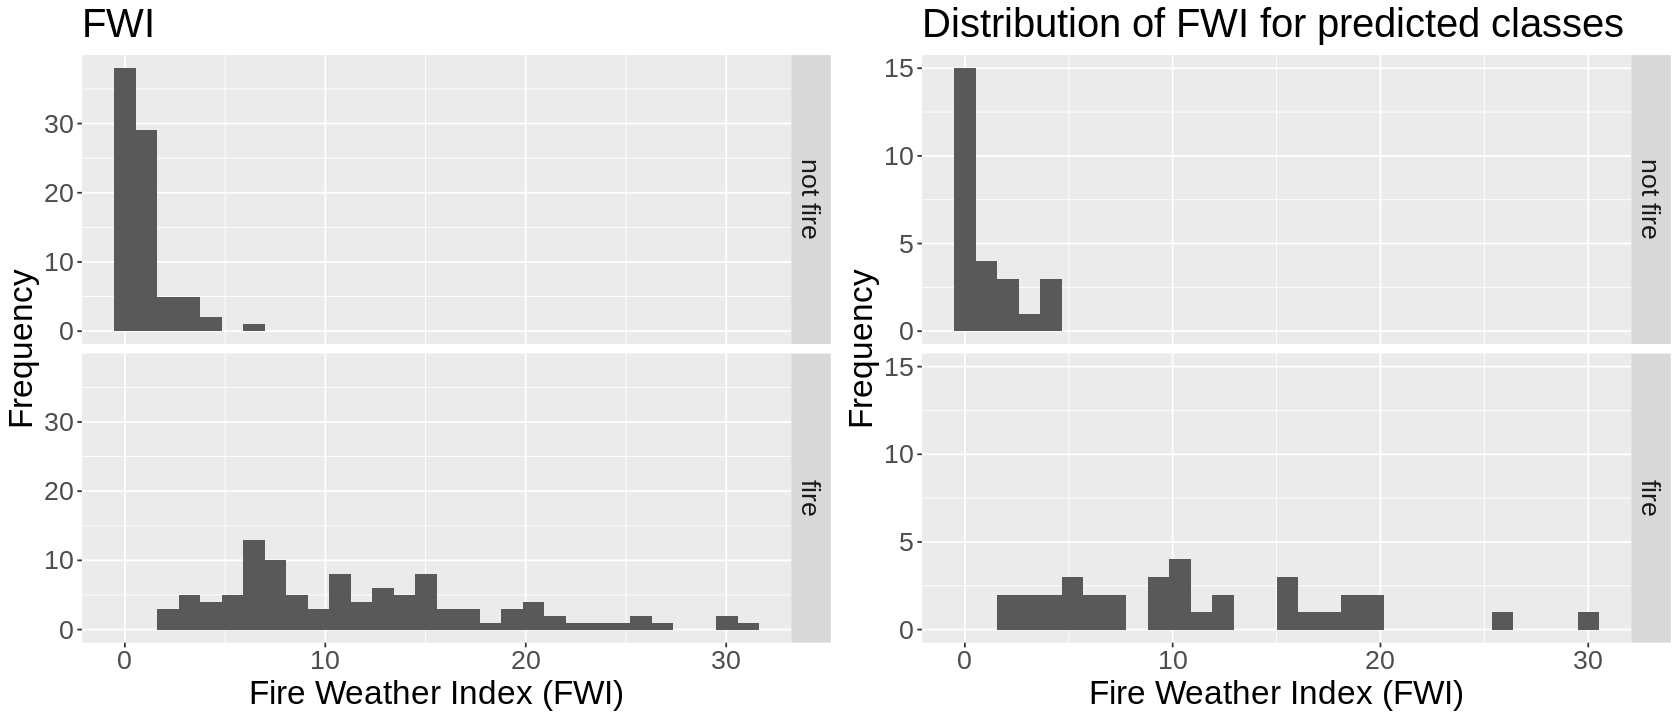

In [99]:
predicted_FWI_dist <- ggplot(fire_test_predictions, aes(x = FWI)) +
    geom_histogram() +
    facet_grid(.pred_class ~ .) +
    labs(x = "Fire Weather Index (FWI)", y = "Frequency", title = "Distribution of FWI for predicted classes") +
    theme(text = element_text(size = 20))

plot_grid(FWI_distribution, predicted_FWI_dist, ncol = 2)

The distributions of relative humidity for the true and predicted classes are also similar in shape. In the training data, there were initially large amounts of overlap in relative humidity between cases of fire and no fire, which has translated to the classifier results. We note that observations with relative humidity below 50% are almost always classified as cases of fire, which aligns with their frequent co-occurrence in the data, but the same cannot be said for those with humidity above 50%.

Overall, the accuracy of the classifier was estimated at 92.9% on testing data with 85 observations; in other words, 6 observations in the test set were classified incorrectly. In real-life applications of the classifier, a 93% accuracy seems sufficient to determine when to organize interventions to prevent forest fires. At the very least, the classifier's results could provide a reasonably reliable assessment of fire risk. Furthermore, this accuracy may be close to the best we can achieve; given the complexity of the environmental conditions that lead to forest fires, it would be impossible to ever create a perfectly accurate classifier. **(I didn't explicitly address potential applications of our analysis here - but if those won't be discussed in the introduction, we can copy them here)**

**(Cite some journal articles too, perhaps)**

The causes of forest fires in Algeria are widely unknown; in 2020, the causation for 85% of fires were unknown (Pons, 2020). Our data analysis could lead to asking whether rainfall, temperature, humidity, or FFMC have a direct causality to fire incidence.

It may also be beneficial to repeat this analysis with additional data. Since the initial dataset, at 244 observations, was not extremely large, both our accuracy estimate and classifier could be improved by increasing the dataset size. **(Not sure if this is true - maybe it needs more justification)**

## References

Aini, A., Curt, T., Bekdouche, F. (2020). Modelling fire hazard in the southern Mediterranean fire rim (Bejaia region, northern Algeria). Retrieved March 03, 2021, from
https://link.springer.com/article/10.1007/s10661-019-7931-0#Sec1

Curt, T., Aini, A., Dupire, S. (2020). Fire activity in Mediterranean forests (The Algerian case). Retrieved March 03, 2021, from
https://www.mendeley.com/catalogue/0ad59940-c469-388c-8796-0685cacb334f/

De Groot, W. J. (1987, April 2). Interpreting the Canadian Forest Fire Weather Index (FWI) System. Retrieved March 03, 2021, from
http://www.dnr.state.mi.us/WWW/FMD/WEATHER/Reference/FWI_Background.pdf

Pons, J. (2020, June 29). Algeria declares land and space war on forest fires. Retrieved March 03, 2021, from https://atalayar.com/en/content/algeria-declares-land-and-space-war-forest-fires